In [40]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy import constants

### constantes
GM=398600.4405*(u.km**3)*(u.s**-2)
e=0.16561
a=(1.30262*u.R_earth).to(u.km) 
omega=15*(u.deg)
tp=Time("2025-03-31T00:00:00")

##### 3ra ley de kepler
T = 2 * np.pi * np.sqrt(a**3 / (GM))

numero_de_tiempos=1000
tiempos = []

# Generar los tiempos desde tp hasta tp + T
for i in range(numero_de_tiempos):
    incremento_tiempo = (i * T / (numero_de_tiempos - 1)).to(u.s)  # Incremento con unidades
    nuevo_tiempo = tp + TimeDelta(incremento_tiempo)  # Sumar el incremento al tiempo inicial
    tiempos.append(nuevo_tiempo)
    


In [41]:
### primer punto


def f(E, l_i):
    return E - e * np.sin(E) - l_i

def df(E):
    return 1 - e * np.cos(E)

def newton_raphson(f, df, x0, l_i, tol=1e-10, iter=100):
    """
    Parámetros:
    - f: Función f(E)
    - df: Derivada de la función f (analítica).
    - x0: Valor inicial.
    - tol: Tolerancia (valor approx 0).
    - iter:iteraciones.
    
    Retorna:
    - Aproximación de la raíz.
    - Número de iteraciones realizadas.
    """
    x = x0
    for i in range(iter):
        fx = f(x, l_i).to(u.dimensionless_unscaled).value 
        dfx = df(x)

        if abs(fx) < tol:
            return x, i  # Convergió

        if dfx == 0:
            raise ValueError("Derivada cero, divide por cero.")

        x -= fx / dfx  # método

    raise ValueError("Revisar parámetros o función.")

E = []
l_values = [np.sqrt((GM) / (a**3)) * ((t_i - tp)) for t_i in tiempos]

for l_i in l_values:
    E0 = l_i.to(u.dimensionless_unscaled).value  ##### es como si e=0
    E_root, _ = newton_raphson(f, df, E0, l_i)
    E.append(E_root)

E = np.array(E) 
f_valor = 2*np.arctan( np.sqrt((1+e)/(1-e)) * np.tan(E/2) )
#### encontrar r
r = (a*(1-e**2)) / (1+e*np.cos(f_valor))
f_valor=np.degrees(f_valor)
phi= f_valor+omega.value



    


In [42]:
def interpolar_lagrange(x, x_vals, y_vals):

    def Lagrange(x, x_a, x_b, x_c):
        return ((x - x_b) * (x - x_c)) / ((x_a - x_b) * (x_a - x_c))

    L0 = Lagrange(x, x_vals[0], x_vals[1], x_vals[2])
    L1 = Lagrange(x, x_vals[1], x_vals[0], x_vals[2])
    L2 = Lagrange(x, x_vals[2], x_vals[0], x_vals[1])

    return y_vals[0] * L0 + y_vals[1] * L1 + y_vals[2] * L2

In [43]:
#### segundo punto

def posicion(t):
    """
    Encuentra la posición (r, φ) en función del tiempo t.
    """
    # Convertir el tiempo a segundos desde tp
    t_sec = (t - tp).to(u.s).value
    t_mod_sec = t_sec % T.value  # Ajuste periódico

    # Crear arreglo de tiempos en segundos
    tiempos_sec = np.array([(t_i - tp).to(u.s).value for t_i in tiempos])

    # Encontrar el índice donde se insertaría t_mod_sec
    idx = np.searchsorted(tiempos_sec, t_mod_sec)
    N = len(tiempos_sec)

    # Seleccionar los tres índices más cercanos considerando la periodicidad
    if idx == 0:
        idxs = [N-1, 0, 1]
    elif idx >= N:
        idxs = [N-2, N-1, 0]
    else:
        idxs = [idx-1, idx, idx+1]

    # Extraer los valores de t, r y phi
    t_vals = tiempos_sec[idxs]
    r_vals = r[idxs]
    phi_vals = phi[idxs]

    # Ajustar tiempos para continuidad en el período
    if t_vals[0] > t_vals[1]:
        t_vals[0] -= T.value
    if t_vals[2] < t_vals[1]:
        t_vals[2] += T.value

    # Interpolar r y phi
    r_interp = interpolar_lagrange(t_mod_sec, t_vals, r_vals)
    phi_interp = interpolar_lagrange(t_mod_sec, t_vals, phi_vals)

    return r_interp, phi_interp




t_dado = Time("2025-04-01T00:00:00")  # Fecha de prueba
resultado = posicion(t_dado)
print("La posición (r, φ) interpolada cuadráticamente en", t_dado.iso, "es:", resultado)


La posición (r, φ) interpolada cuadráticamente en 2025-04-01 00:00:00.000 es: (<Quantity 9658.40915151 km>, np.float64(185.59671048636332))


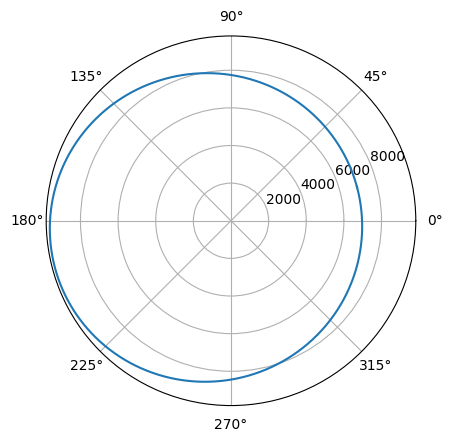

In [44]:
#tercer punto
def orbit():
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    phi_rad = np.radians(phi)
    plt.plot(phi_rad,r)
    plt.show()
orbit()

In [45]:
def date(r0):
    """
    Encuentra la fecha en la que la órbita alcanza r0 usando interpolación de Lagrange.

    Parámetros:
    - r0: Radio en metros.

    Retorna:
    - Fecha en formato `Time`.
    - Incertidumbre en segundos.
    """
    # Convertir la incertidumbre de km a m
    delta_r = (1.28342948e-6 * u.km).value  

    # Convertir tiempos a segundos desde tp
    tiempos_sec = np.array([(t_i - tp).to(u.s).value for t_i in tiempos])
    
    # Encontrar los 3 puntos más cercanos a r0
    idx = np.searchsorted(r, r0)
    N = len(r)
    
    if idx == 0:
        idxs = [0, 1, 2]
    elif idx >= N - 1:
        idxs = [N - 3, N - 2, N - 1]
    else:
        idxs = [idx - 1, idx, idx + 1]

    # Extraer valores para la interpolación
    r_vals = r[idxs]
    t_vals = tiempos_sec[idxs]

    # Interpolar t(r0)
    t_sol = interpolar_lagrange(r0, r_vals, t_vals)

    

    # Convertir t_sol a fecha
    fecha_sol = tp + TimeDelta(t_sol * u.s)
    
    return fecha_sol

print(date((1.5*u.R_earth).to(u.km)))

2025-03-31T00:53:09.855
